# Training on Generic Features

The features to be trained on:

**Numerical**
1. Budget
2. Release Date (Extract month)
3. Runtime
4. View Count
5. Like Count
6. Favorite Count
7. Comment Count

**Categorical**
1. Genre

Model used: **LightGBM**

## Training Dataset Preparation

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

df = pd.read_csv('movie_data_train.csv')

numerical_features = ['budget', 'runtime', 'viewCount', 'likeCount', 'favoriteCount', 'commentCount']

df['release_month'] = pd.to_datetime(df['release_date']).dt.month

df['genres_list'] = df['genres'].str.split(',')

X_numeric = df[numerical_features + ['release_month']]
y = df['revenue']

genres_exploded = df['genres_list'].explode()
unique_genres = genres_exploded.dropna().unique()

for genre in unique_genres:
    df[f'genre_{genre.strip()}'] = df['genres_list'].apply(
        lambda x: 1 if x is not None and genre in [g.strip() for g in x] else 0
    )

genre_columns = [col for col in df.columns if col.startswith('genre_')]

X_combined = pd.concat([X_numeric, df[genre_columns]], axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

imputer = SimpleImputer(strategy='constant', fill_value=0)

X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")


Training data shape: (2786, 26)
Validation data shape: (697, 26)


## Test Dataset Preparation

In [4]:
test_df = pd.read_csv('movie_data_test.csv')

test_df['release_month'] = pd.to_datetime(test_df['release_date']).dt.month
test_df['genres_list'] = test_df['genres'].str.split(',')

X_test_numeric = test_df[numerical_features + ['release_month']]

for genre in unique_genres:
    test_df[f'genre_{genre.strip()}'] = test_df['genres_list'].apply(
        lambda x: 1 if x is not None and genre in [g.strip() for g in x] else 0
    )

X_test = pd.concat([X_test_numeric, test_df[genre_columns]], axis=1)

print(f"Test data shape: {X_test.shape}")

X_test = SimpleImputer(strategy='constant', fill_value=0).fit_transform(X_test)

y_test = test_df['revenue']
print(f"Test target shape: {y_test.shape}")



Test data shape: (871, 26)
Test target shape: (871,)


## Linear Regression

Test R²: 0.5853
Test RMSE: 137538161.60
Test MAE: 64278516.37
Linear Regression Results:
Training RMSE: 118299689.13
Validation RMSE: 149168928.60
Test RMSE: 137538161.60
Training MAE: 61914747.99
Validation MAE: 66503705.01
Test MAE: 64278516.37
Training R²: 0.5981
Validation R²: 0.5421
Test R²: 0.5853


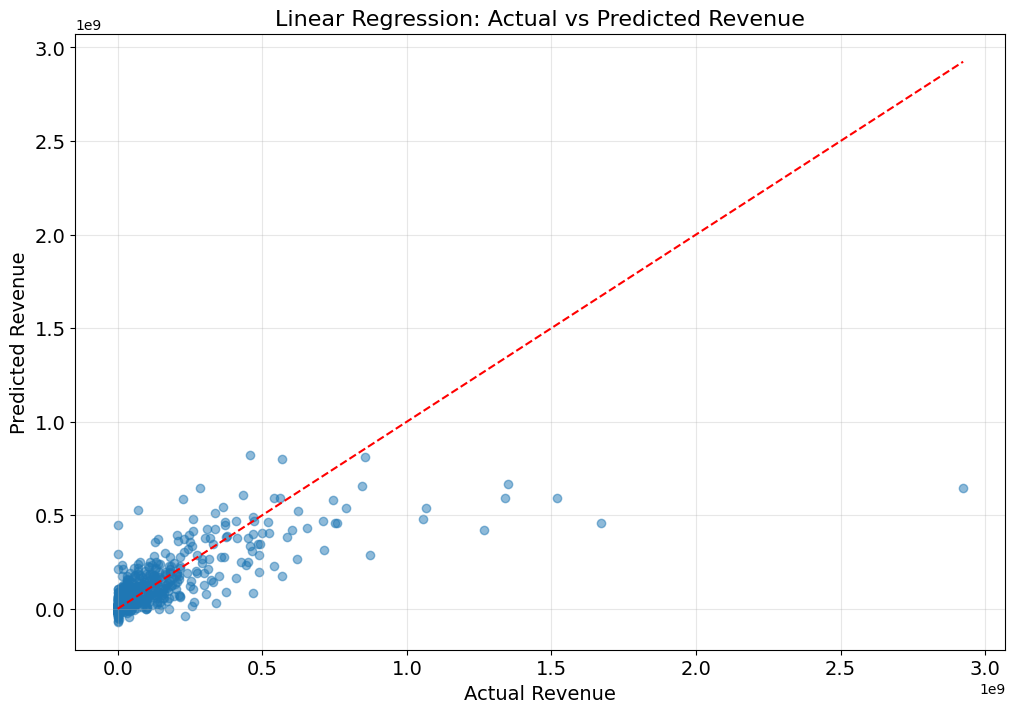

Top 3 features with most positive impact:
            Feature   Coefficient
21  genre_Animation  5.134062e+07
8     genre_Romance  3.607800e+06
1           runtime  7.230168e+05

Top 3 features with most negative impact:
          Feature   Coefficient
22  genre_Western -5.569037e+07
17      genre_War -5.354861e+07
16  genre_History -2.985445e+07


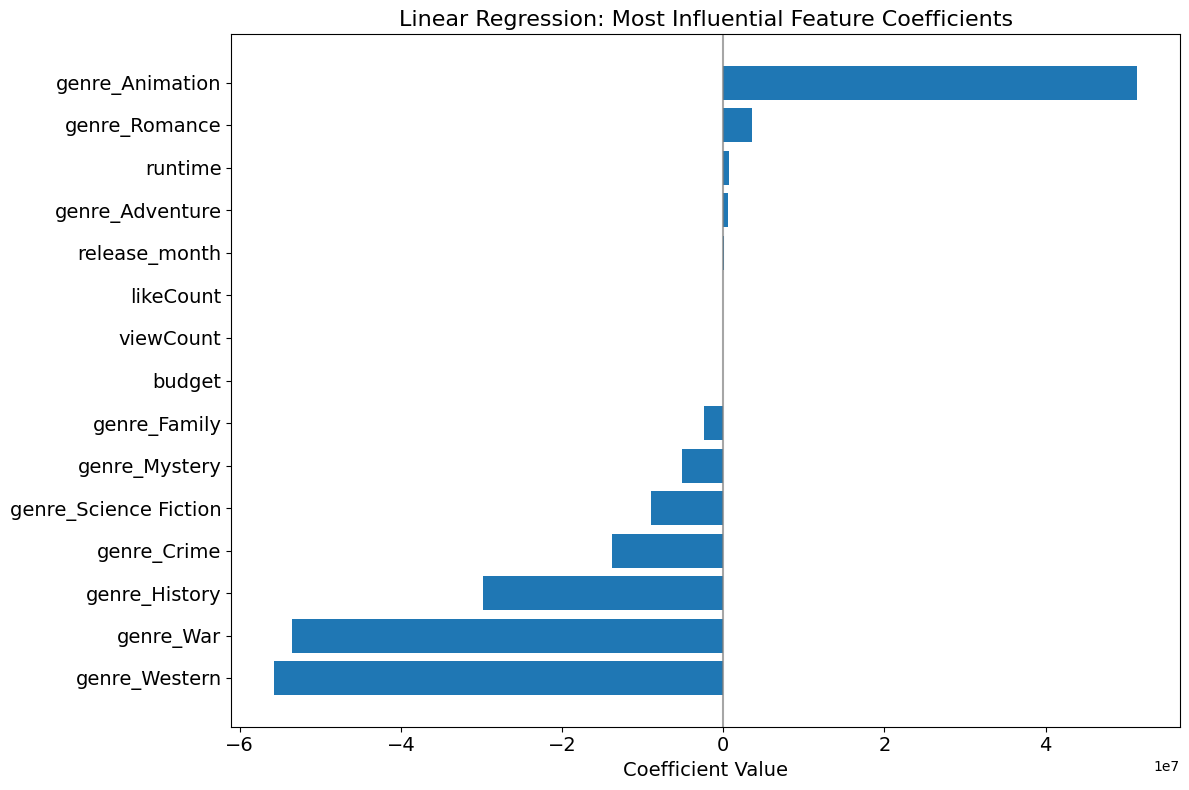

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

y_train_pred = linear_model.predict(X_train)
y_val_pred = linear_model.predict(X_val)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

y_test_pred = linear_model.predict(X_test)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test R²: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")


print(f"Linear Regression Results:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 8))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
# Increase font size for labels and title
plt.xlabel('Actual Revenue', fontsize=14)
plt.ylabel('Predicted Revenue', fontsize=14)
plt.title('Linear Regression: Actual vs Predicted Revenue', fontsize=16)
# Add grid for better readability
plt.grid(True, alpha=0.3)
# Increase tick label font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': X_combined.columns,
    'Coefficient': linear_model.coef_
})

# Sort by coefficient value (not absolute value)
most_positive = feature_importance.sort_values('Coefficient', ascending=False)
most_negative = feature_importance.sort_values('Coefficient', ascending=True)

# Print top 3 most positive features
print("Top 3 features with most positive impact:")
print(most_positive.head(3))

# Print top 3 most negative features
print("\nTop 3 features with most negative impact:")
print(most_negative.head(3))

# Create a combined dataframe for visualization
top_features = pd.concat([
    most_positive.head(8),
    most_negative.head(7)
])

plt.figure(figsize=(12, 8))
# Sort by coefficient for the plot to show in order
top_features = top_features.sort_values('Coefficient')
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Coefficient Value', fontsize=14)
plt.title('Linear Regression: Most Influential Feature Coefficients', fontsize=16)
# Add a vertical line at x=0 to clearly separate positive and negative
plt.axvline(x=0, color='gray', linestyle='-', alpha=0.7)
# Increase tick label font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


## LightGBM

Training with n_estimators=500, num_leaves=2
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.5504, Val=0.5058, Test=0.5556
  RMSE Train=1.251e+08, Val=1.550e+08, Test=1.424e+08
  MAE Train=6.660e+07, Val=7.084e+07, Test=6.998e+07
Training with n_estimators=500, num_leaves=3
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.5848, Val=0.5426, Test=0.5898
  RMSE Train=1.202e+08, Val=1.491e+08, Test=1.368e+08
  MAE Train=6.225e+07, Val=6.603e+07, Test=6.569e+07
Training with n_estimators=500, num_leaves=4
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.6038, Val=0.5574, Test=0.5946
  RMSE Train=1.175e+08, Val=1.467e+08, Test=1.360e+08
  MAE Train=6.064e+07, Val=6.451e+07, Test=6.487e+07
Training with n_estimators=500, num_leaves=5
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.6198, Val=0.5638, Test=0.5985
  RMSE Train=1.151e+08, Val=1.456e+08, Test=1.353e+08
  MAE Train=5.919e+07, Val=6.355e+07, Test=6.406e+07
Training with n_estimators=500, num_leaves=10
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.6568, Val=0.5726, Test=0.6001
  RMSE Train=1.093e+08, Val=1.441e+08, Test=1.351e+08
  MAE Train=5.613e+07, Val=6.216e+07, Test=6.313e+07
Training with n_estimators=1000, num_leaves=2
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.5769, Val=0.5452, Test=0.5926
  RMSE Train=1.214e+08, Val=1.487e+08, Test=1.363e+08
  MAE Train=6.162e+07, Val=6.572e+07, Test=6.461e+07
Training with n_estimators=1000, num_leaves=3
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.6123, Val=0.5704, Test=0.6069
  RMSE Train=1.162e+08, Val=1.445e+08, Test=1.339e+08
  MAE Train=5.828e+07, Val=6.245e+07, Test=6.256e+07
Training with n_estimators=1000, num_leaves=4
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.6344, Val=0.5811, Test=0.6086
  RMSE Train=1.128e+08, Val=1.427e+08, Test=1.336e+08
  MAE Train=5.671e+07, Val=6.151e+07, Test=6.223e+07
Training with n_estimators=1000, num_leaves=5
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.6521, Val=0.5841, Test=0.6081
  RMSE Train=1.101e+08, Val=1.422e+08, Test=1.337e+08
  MAE Train=5.569e+07, Val=6.138e+07, Test=6.212e+07
Training with n_estimators=1000, num_leaves=10
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.7030, Val=0.5876, Test=0.6033
  RMSE Train=1.017e+08, Val=1.416e+08, Test=1.345e+08
  MAE Train=5.235e+07, Val=6.162e+07, Test=6.261e+07
Training with n_estimators=1500, num_leaves=2
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.5841, Val=0.5526, Test=0.5974
  RMSE Train=1.203e+08, Val=1.475e+08, Test=1.355e+08
  MAE Train=6.044e+07, Val=6.448e+07, Test=6.364e+07
Training with n_estimators=1500, num_leaves=3
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.6233, Val=0.5778, Test=0.6096
  RMSE Train=1.145e+08, Val=1.432e+08, Test=1.335e+08
  MAE Train=5.728e+07, Val=6.197e+07, Test=6.222e+07
Training with n_estimators=1500, num_leaves=4
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.6502, Val=0.5864, Test=0.6082
  RMSE Train=1.104e+08, Val=1.418e+08, Test=1.337e+08
  MAE Train=5.576e+07, Val=6.158e+07, Test=6.230e+07
Training with n_estimators=1500, num_leaves=5
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.6703, Val=0.5892, Test=0.6081
  RMSE Train=1.071e+08, Val=1.413e+08, Test=1.337e+08
  MAE Train=5.465e+07, Val=6.162e+07, Test=6.207e+07
Training with n_estimators=1500, num_leaves=10
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.7322, Val=0.5889, Test=0.5992
  RMSE Train=9.656e+07, Val=1.413e+08, Test=1.352e+08
  MAE Train=5.033e+07, Val=6.219e+07, Test=6.293e+07
Training with n_estimators=2000, num_leaves=2
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.5890, Val=0.5560, Test=0.5983
  RMSE Train=1.196e+08, Val=1.469e+08, Test=1.354e+08
  MAE Train=6.000e+07, Val=6.415e+07, Test=6.355e+07
Training with n_estimators=2000, num_leaves=3
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.6313, Val=0.5803, Test=0.6069
  RMSE Train=1.133e+08, Val=1.428e+08, Test=1.339e+08
  MAE Train=5.689e+07, Val=6.212e+07, Test=6.239e+07
Training with n_estimators=2000, num_leaves=4
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.6616, Val=0.5901, Test=0.6071
  RMSE Train=1.085e+08, Val=1.411e+08, Test=1.339e+08
  MAE Train=5.514e+07, Val=6.175e+07, Test=6.236e+07
Training with n_estimators=2000, num_leaves=5
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.6845, Val=0.5929, Test=0.6068
  RMSE Train=1.048e+08, Val=1.407e+08, Test=1.339e+08
  MAE Train=5.387e+07, Val=6.176e+07, Test=6.218e+07
Training with n_estimators=2000, num_leaves=10
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.7537, Val=0.5893, Test=0.5962
  RMSE Train=9.260e+07, Val=1.413e+08, Test=1.357e+08
  MAE Train=4.884e+07, Val=6.265e+07, Test=6.330e+07
Training with n_estimators=2500, num_leaves=2
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.5928, Val=0.5582, Test=0.5988
  RMSE Train=1.191e+08, Val=1.465e+08, Test=1.353e+08
  MAE Train=5.977e+07, Val=6.403e+07, Test=6.354e+07
Training with n_estimators=2500, num_leaves=3
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.6387, Val=0.5830, Test=0.6057
  RMSE Train=1.122e+08, Val=1.424e+08, Test=1.341e+08
  MAE Train=5.651e+07, Val=6.235e+07, Test=6.246e+07
Training with n_estimators=2500, num_leaves=4
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.6708, Val=0.5928, Test=0.6059
  RMSE Train=1.071e+08, Val=1.407e+08, Test=1.341e+08
  MAE Train=5.469e+07, Val=6.203e+07, Test=6.258e+07
Training with n_estimators=2500, num_leaves=5
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  R² Train=0.6970, Val=0.5942, Test=0.6030
  RMSE Train=1.027e+08, Val=1.404e+08, Test=1.346e+08
  MAE Train=5.326e+07, Val=6.188e+07, Test=6.261e+07
Training with n_estimators=2500, num_leaves=10
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 16
[LightGBM] [Info] Start training from score 97118870.217516
  R² Train=0.7702, Val=0.5894, Test=0.5957
  RMSE Train=8.944e+07, Val=1.412e+08, Test=1.358e+08
  MAE Train=4.761e+07, Val=6.310e+07, Test=6.367e+07


/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/nigelpoh/Desktop/SUTD/Computational Data Science/Project/cds_project/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


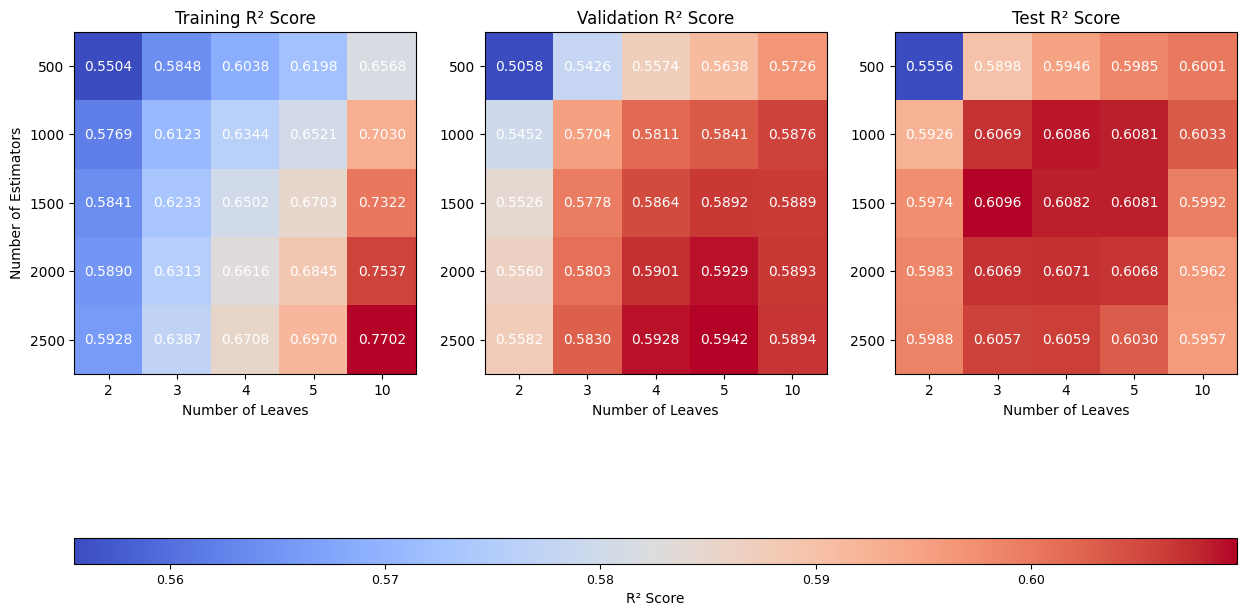

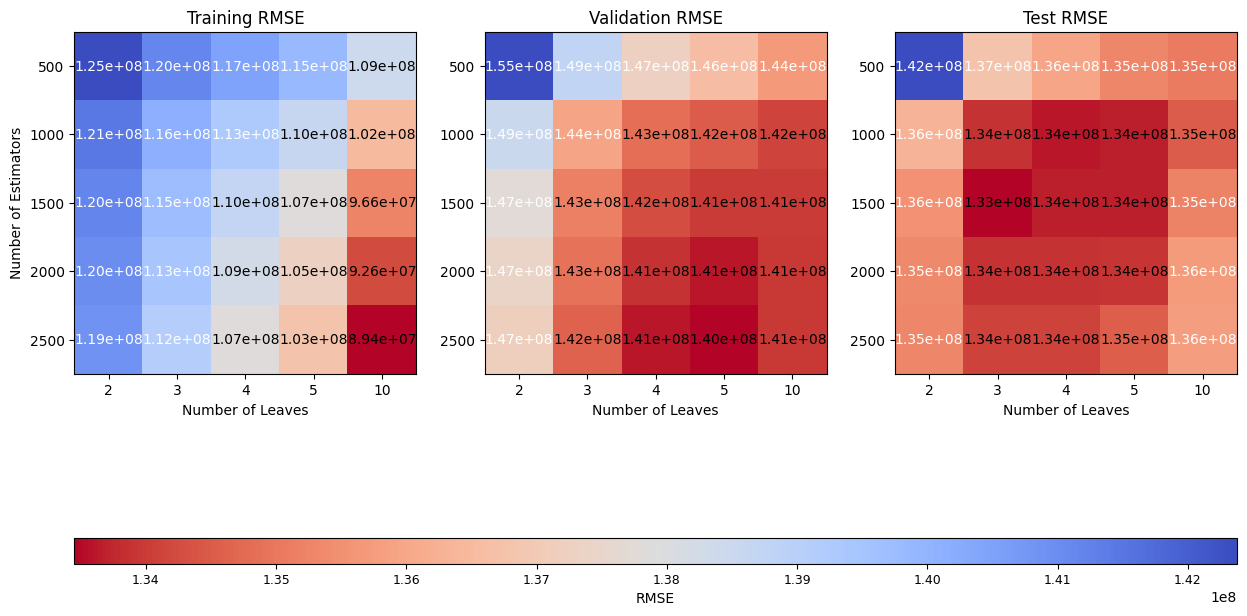

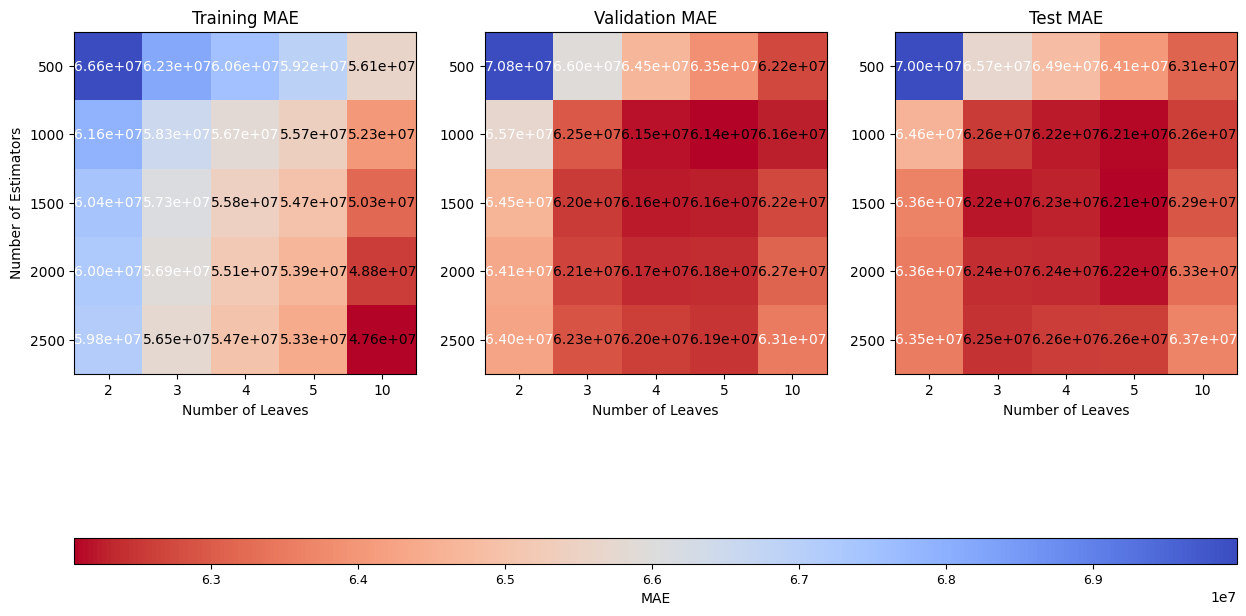

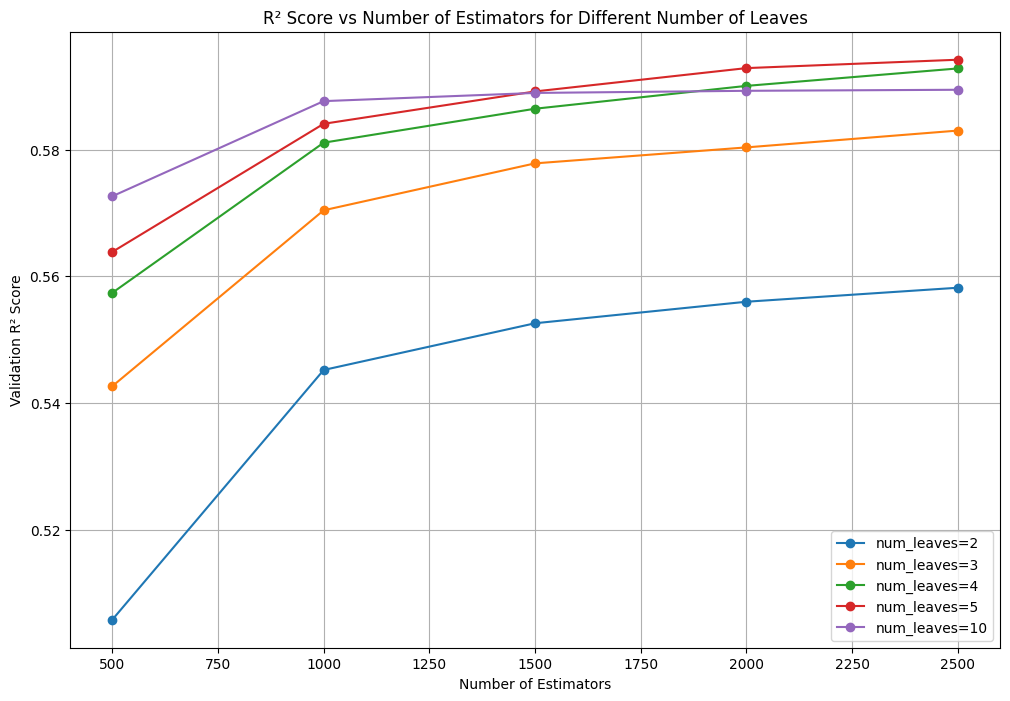

Best hyperparameters: n_estimators=2500, num_leaves=5
Best R² scores: Train=0.6970, Val=0.5942, Test=0.6030
Best RMSE scores: Train=1.027e+08, Val=1.404e+08, Test=1.346e+08
Best MAE scores: Train=5.326e+07, Val=6.188e+07, Test=6.261e+07


In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.gridspec as gridspec
import lightgbm as lgb

n_estimators_range = [500, 1000, 1500, 2000, 2500]
num_leaves_range = [2, 3, 4, 5, 10]

results = {}

for n_est in n_estimators_range:
    for num_leaves in num_leaves_range:
        print(f"Training with n_estimators={n_est}, num_leaves={num_leaves}")
        
        model = lgb.LGBMRegressor(
            n_estimators=n_est,
            learning_rate=0.01,
            num_leaves=num_leaves,
            subsample=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            colsample_bytree=0.5,
            random_state=42,
            min_child_samples=40,
            max_depth=12,
            force_row_wise=True 
        )
        
        model.fit(
            X_train, y_train.values,
            eval_set=[(X_val, y_val.values)],
            eval_metric='rmse'
        )
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
        
        r2_train = r2_score(y_train, y_train_pred)
        r2_val = r2_score(y_val, y_val_pred)
        r2_test = r2_score(y_test, y_test_pred)
        
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_val = mean_absolute_error(y_val, y_val_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        
        results[(n_est, num_leaves)] = {
            'train': {'r2': r2_train, 'rmse': rmse_train, 'mae': mae_train},
            'val': {'r2': r2_val, 'rmse': rmse_val, 'mae': mae_val},
            'test': {'r2': r2_test, 'rmse': rmse_test, 'mae': mae_test}
        }
        
        print(f"  R² Train={r2_train:.4f}, Val={r2_val:.4f}, Test={r2_test:.4f}")
        print(f"  RMSE Train={rmse_train:.3e}, Val={rmse_val:.3e}, Test={rmse_test:.3e}")
        print(f"  MAE Train={mae_train:.3e}, Val={mae_val:.3e}, Test={mae_test:.3e}")

r2_train_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))
r2_val_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))
r2_test_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))

rmse_train_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))
rmse_val_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))
rmse_test_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))

mae_train_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))
mae_val_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))
mae_test_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))

for i, n_est in enumerate(n_estimators_range):
    for j, num_leaves in enumerate(num_leaves_range):
        r2_train_matrix[i, j] = results[(n_est, num_leaves)]['train']['r2']
        r2_val_matrix[i, j] = results[(n_est, num_leaves)]['val']['r2']
        r2_test_matrix[i, j] = results[(n_est, num_leaves)]['test']['r2']
        
        rmse_train_matrix[i, j] = results[(n_est, num_leaves)]['train']['rmse']
        rmse_val_matrix[i, j] = results[(n_est, num_leaves)]['val']['rmse']
        rmse_test_matrix[i, j] = results[(n_est, num_leaves)]['test']['rmse']
        
        mae_train_matrix[i, j] = results[(n_est, num_leaves)]['train']['mae']
        mae_val_matrix[i, j] = results[(n_est, num_leaves)]['val']['mae']
        mae_test_matrix[i, j] = results[(n_est, num_leaves)]['test']['mae']

fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[20, 1], hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

im0 = axes[0].imshow(r2_train_matrix, interpolation='nearest', cmap='coolwarm')
axes[0].set_xticks(np.arange(len(num_leaves_range)))
axes[0].set_yticks(np.arange(len(n_estimators_range)))
axes[0].set_xticklabels(num_leaves_range)
axes[0].set_yticklabels(n_estimators_range)
axes[0].set_xlabel('Number of Leaves')
axes[0].set_ylabel('Number of Estimators')
axes[0].set_title('Training R² Score')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[0].text(j, i, f"{r2_train_matrix[i, j]:.4f}", 
                 ha="center", va="center", color="white" if r2_train_matrix[i, j] < 0.85 else "black")

im1 = axes[1].imshow(r2_val_matrix, interpolation='nearest', cmap='coolwarm')
axes[1].set_xticks(np.arange(len(num_leaves_range)))
axes[1].set_yticks(np.arange(len(n_estimators_range)))
axes[1].set_xticklabels(num_leaves_range)
axes[1].set_yticklabels(n_estimators_range)
axes[1].set_xlabel('Number of Leaves')
axes[1].set_title('Validation R² Score')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[1].text(j, i, f"{r2_val_matrix[i, j]:.4f}", 
                 ha="center", va="center", color="white" if r2_val_matrix[i, j] < 0.85 else "black")

im2 = axes[2].imshow(r2_test_matrix, interpolation='nearest', cmap='coolwarm')
axes[2].set_xticks(np.arange(len(num_leaves_range)))
axes[2].set_yticks(np.arange(len(n_estimators_range)))
axes[2].set_xticklabels(num_leaves_range)
axes[2].set_yticklabels(n_estimators_range)
axes[2].set_xlabel('Number of Leaves')
axes[2].set_title('Test R² Score')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[2].text(j, i, f"{r2_test_matrix[i, j]:.4f}", 
                 ha="center", va="center", color="white" if r2_test_matrix[i, j] < 0.85 else "black")

fig_bbox = fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
l, b, w, h = fig_bbox.bounds

cax = fig.add_subplot(gs[1, :])
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal', pad=0.08)
cbar.set_label('R² Score', fontsize=10)
cbar.ax.tick_params(labelsize=9)

plt.show()

fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[20, 1], hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

im0 = axes[0].imshow(rmse_train_matrix, interpolation='nearest', cmap='coolwarm_r')
axes[0].set_xticks(np.arange(len(num_leaves_range)))
axes[0].set_yticks(np.arange(len(n_estimators_range)))
axes[0].set_xticklabels(num_leaves_range)
axes[0].set_yticklabels(n_estimators_range)
axes[0].set_xlabel('Number of Leaves')
axes[0].set_ylabel('Number of Estimators')
axes[0].set_title('Training RMSE')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[0].text(j, i, f"{rmse_train_matrix[i, j]:.2e}", 
                 ha="center", va="center", color="white" if rmse_train_matrix[i, j] > np.mean(rmse_train_matrix) else "black")

im1 = axes[1].imshow(rmse_val_matrix, interpolation='nearest', cmap='coolwarm_r')
axes[1].set_xticks(np.arange(len(num_leaves_range)))
axes[1].set_yticks(np.arange(len(n_estimators_range)))
axes[1].set_xticklabels(num_leaves_range)
axes[1].set_yticklabels(n_estimators_range)
axes[1].set_xlabel('Number of Leaves')
axes[1].set_title('Validation RMSE')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[1].text(j, i, f"{rmse_val_matrix[i, j]:.2e}", 
                 ha="center", va="center", color="white" if rmse_val_matrix[i, j] > np.mean(rmse_val_matrix) else "black")

im2 = axes[2].imshow(rmse_test_matrix, interpolation='nearest', cmap='coolwarm_r')
axes[2].set_xticks(np.arange(len(num_leaves_range)))
axes[2].set_yticks(np.arange(len(n_estimators_range)))
axes[2].set_xticklabels(num_leaves_range)
axes[2].set_yticklabels(n_estimators_range)
axes[2].set_xlabel('Number of Leaves')
axes[2].set_title('Test RMSE')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[2].text(j, i, f"{rmse_test_matrix[i, j]:.2e}", 
                 ha="center", va="center", color="white" if rmse_test_matrix[i, j] > np.mean(rmse_test_matrix) else "black")

cax = fig.add_subplot(gs[1, :])
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal', pad=0.08)
cbar.set_label('RMSE', fontsize=10)
cbar.ax.tick_params(labelsize=9)

plt.show()

fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[20, 1], hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

im0 = axes[0].imshow(mae_train_matrix, interpolation='nearest', cmap='coolwarm_r')
axes[0].set_xticks(np.arange(len(num_leaves_range)))
axes[0].set_yticks(np.arange(len(n_estimators_range)))
axes[0].set_xticklabels(num_leaves_range)
axes[0].set_yticklabels(n_estimators_range)
axes[0].set_xlabel('Number of Leaves')
axes[0].set_ylabel('Number of Estimators')
axes[0].set_title('Training MAE')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[0].text(j, i, f"{mae_train_matrix[i, j]:.2e}", 
                 ha="center", va="center", color="white" if mae_train_matrix[i, j] > np.mean(mae_train_matrix) else "black")

im1 = axes[1].imshow(mae_val_matrix, interpolation='nearest', cmap='coolwarm_r')
axes[1].set_xticks(np.arange(len(num_leaves_range)))
axes[1].set_yticks(np.arange(len(n_estimators_range)))
axes[1].set_xticklabels(num_leaves_range)
axes[1].set_yticklabels(n_estimators_range)
axes[1].set_xlabel('Number of Leaves')
axes[1].set_title('Validation MAE')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[1].text(j, i, f"{mae_val_matrix[i, j]:.2e}", 
                 ha="center", va="center", color="white" if mae_val_matrix[i, j] > np.mean(mae_val_matrix) else "black")

im2 = axes[2].imshow(mae_test_matrix, interpolation='nearest', cmap='coolwarm_r')
axes[2].set_xticks(np.arange(len(num_leaves_range)))
axes[2].set_yticks(np.arange(len(n_estimators_range)))
axes[2].set_xticklabels(num_leaves_range)
axes[2].set_yticklabels(n_estimators_range)
axes[2].set_xlabel('Number of Leaves')
axes[2].set_title('Test MAE')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[2].text(j, i, f"{mae_test_matrix[i, j]:.2e}", 
                 ha="center", va="center", color="white" if mae_test_matrix[i, j] > np.mean(mae_test_matrix) else "black")

cax = fig.add_subplot(gs[1, :])
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal', pad=0.08)
cbar.set_label('MAE', fontsize=10)
cbar.ax.tick_params(labelsize=9)

plt.show()


Training with n_estimators=500, num_leaves=5
  R² Train=0.6093, Val=0.5617, Test=0.6008
  RMSE Train=1.166e+08, Val=1.459e+08, Test=1.349e+08
  MAE Train=5.805e+07, Val=6.217e+07, Test=6.152e+07
Training with n_estimators=500, num_leaves=10
  R² Train=0.6371, Val=0.5645, Test=0.6034
  RMSE Train=1.124e+08, Val=1.455e+08, Test=1.345e+08
  MAE Train=5.575e+07, Val=6.207e+07, Test=6.141e+07
Training with n_estimators=500, num_leaves=20
  R² Train=0.6444, Val=0.5628, Test=0.6022
  RMSE Train=1.113e+08, Val=1.458e+08, Test=1.347e+08
  MAE Train=5.492e+07, Val=6.243e+07, Test=6.162e+07
Training with n_estimators=500, num_leaves=30
  R² Train=0.6450, Val=0.5626, Test=0.6014
  RMSE Train=1.112e+08, Val=1.458e+08, Test=1.348e+08
  MAE Train=5.486e+07, Val=6.241e+07, Test=6.170e+07
Training with n_estimators=500, num_leaves=40
  R² Train=0.6450, Val=0.5626, Test=0.6014
  RMSE Train=1.112e+08, Val=1.458e+08, Test=1.348e+08
  MAE Train=5.486e+07, Val=6.241e+07, Test=6.170e+07
Training with n_estim

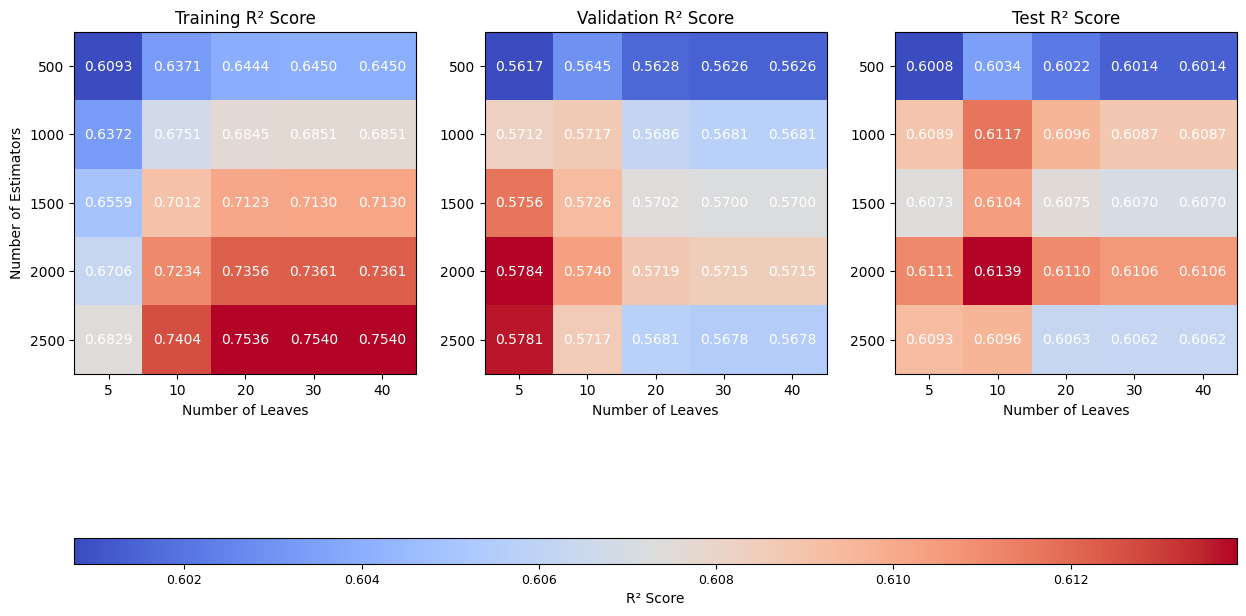

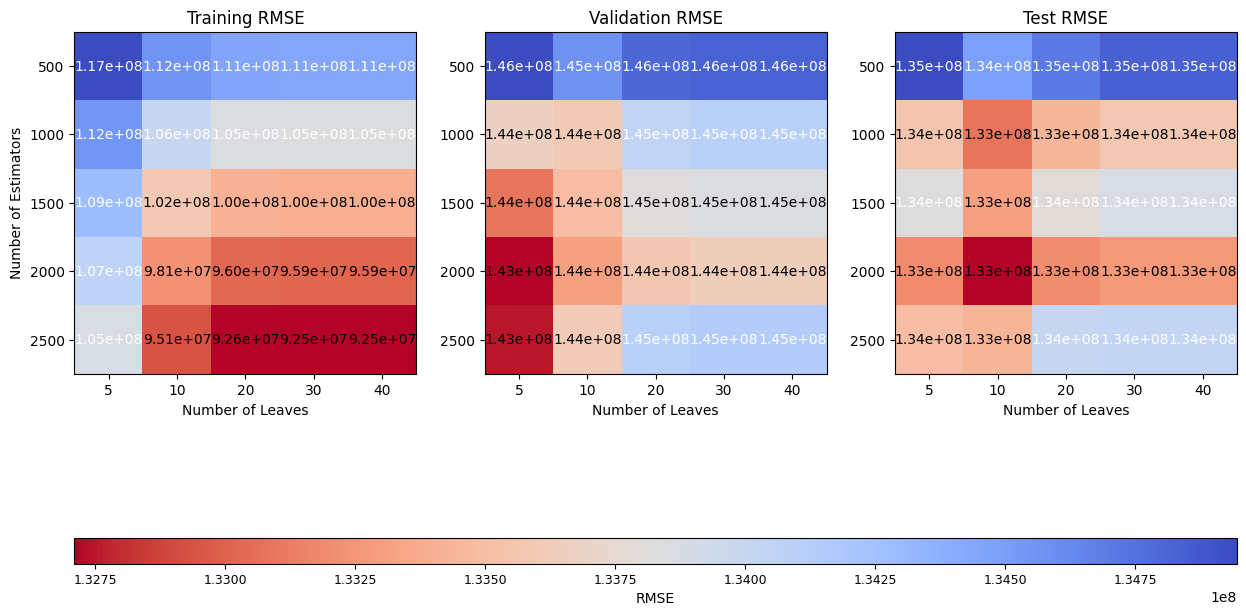

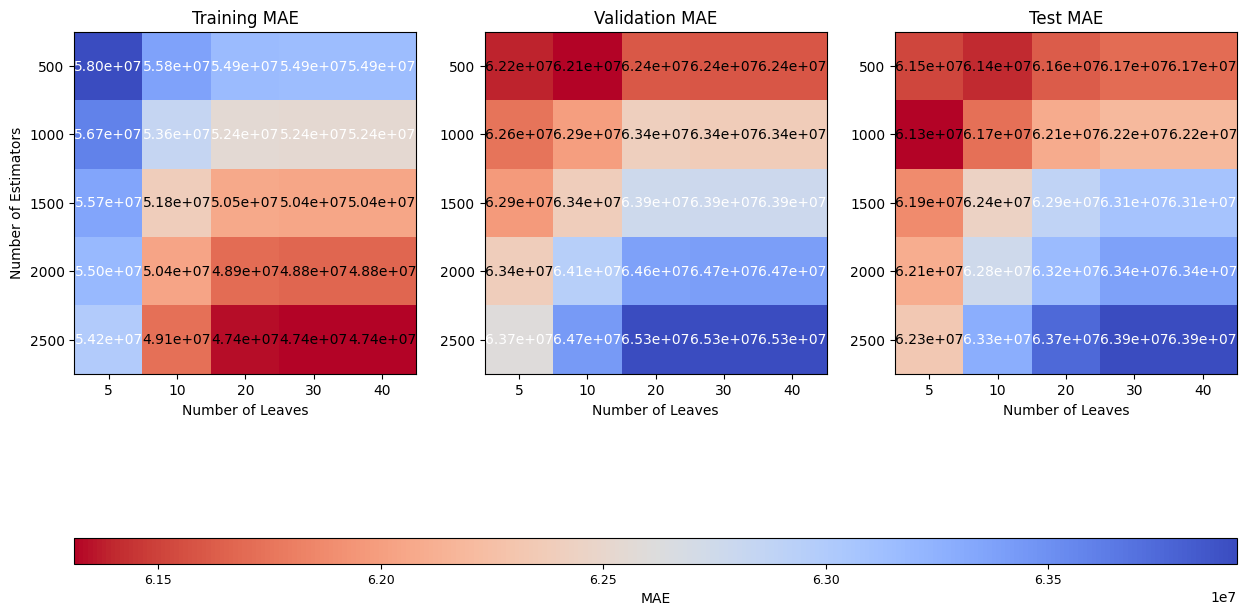

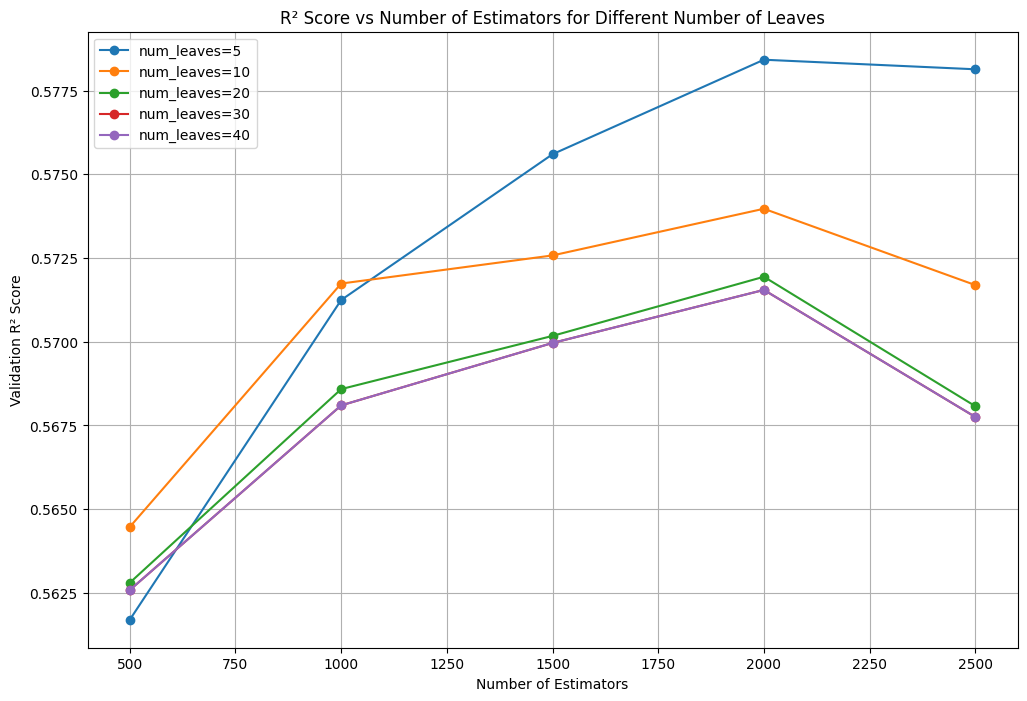

Best hyperparameters: n_estimators=2000, num_leaves=5
Best R² scores: Train=0.6706, Val=0.5784, Test=0.6111
Best RMSE scores: Train=1.071e+08, Val=1.431e+08, Test=1.332e+08
Best MAE scores: Train=5.502e+07, Val=6.341e+07, Test=6.211e+07


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.gridspec as gridspec
import xgboost as xgb

n_estimators_range = [500, 1000, 1500, 2000, 2500]
num_leaves_range = [5, 10, 20, 30, 40]

results = {}

for n_est in n_estimators_range:
    for num_leaves in num_leaves_range:
        print(f"Training with n_estimators={n_est}, num_leaves={num_leaves}")
        
        model = xgb.XGBRegressor(
            n_estimators=n_est,
            learning_rate=0.015,
            max_leaves=num_leaves,
            subsample=0.5,
            colsample_bytree=0.6,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=42,
            min_child_weight=40,
            tree_method="hist", 
            verbosity=0
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)

        
        r2_train = r2_score(y_train, y_train_pred)
        r2_val = r2_score(y_val, y_val_pred)
        r2_test = r2_score(y_test, y_test_pred)
        
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_val = mean_absolute_error(y_val, y_val_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        
        results[(n_est, num_leaves)] = {
            'train': {'r2': r2_train, 'rmse': rmse_train, 'mae': mae_train},
            'val': {'r2': r2_val, 'rmse': rmse_val, 'mae': mae_val},
            'test': {'r2': r2_test, 'rmse': rmse_test, 'mae': mae_test}
        }
        
        print(f"  R² Train={r2_train:.4f}, Val={r2_val:.4f}, Test={r2_test:.4f}")
        print(f"  RMSE Train={rmse_train:.3e}, Val={rmse_val:.3e}, Test={rmse_test:.3e}")
        print(f"  MAE Train={mae_train:.3e}, Val={mae_val:.3e}, Test={mae_test:.3e}")

r2_train_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))
r2_val_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))
r2_test_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))
rmse_train_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))
rmse_val_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))
rmse_test_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))
mae_train_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))
mae_val_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))
mae_test_matrix = np.zeros((len(n_estimators_range), len(num_leaves_range)))

for i, n_est in enumerate(n_estimators_range):
    for j, num_leaves in enumerate(num_leaves_range):
        r2_train_matrix[i, j] = results[(n_est, num_leaves)]['train']['r2']
        r2_val_matrix[i, j] = results[(n_est, num_leaves)]['val']['r2']
        r2_test_matrix[i, j] = results[(n_est, num_leaves)]['test']['r2']
        rmse_train_matrix[i, j] = results[(n_est, num_leaves)]['train']['rmse']
        rmse_val_matrix[i, j] = results[(n_est, num_leaves)]['val']['rmse']
        rmse_test_matrix[i, j] = results[(n_est, num_leaves)]['test']['rmse']
        mae_train_matrix[i, j] = results[(n_est, num_leaves)]['train']['mae']
        mae_val_matrix[i, j] = results[(n_est, num_leaves)]['val']['mae']
        mae_test_matrix[i, j] = results[(n_est, num_leaves)]['test']['mae']

fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[20, 1], hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

im0 = axes[0].imshow(r2_train_matrix, interpolation='nearest', cmap='coolwarm')
axes[0].set_xticks(np.arange(len(num_leaves_range)))
axes[0].set_yticks(np.arange(len(n_estimators_range)))
axes[0].set_xticklabels(num_leaves_range)
axes[0].set_yticklabels(n_estimators_range)
axes[0].set_xlabel('Number of Leaves')
axes[0].set_ylabel('Number of Estimators')
axes[0].set_title('Training R² Score')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[0].text(j, i, f"{r2_train_matrix[i, j]:.4f}", 
                 ha="center", va="center", color="white" if r2_train_matrix[i, j] < 0.85 else "black")

im1 = axes[1].imshow(r2_val_matrix, interpolation='nearest', cmap='coolwarm')
axes[1].set_xticks(np.arange(len(num_leaves_range)))
axes[1].set_yticks(np.arange(len(n_estimators_range)))
axes[1].set_xticklabels(num_leaves_range)
axes[1].set_yticklabels(n_estimators_range)
axes[1].set_xlabel('Number of Leaves')
axes[1].set_title('Validation R² Score')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[1].text(j, i, f"{r2_val_matrix[i, j]:.4f}", 
                 ha="center", va="center", color="white" if r2_val_matrix[i, j] < 0.85 else "black")

im2 = axes[2].imshow(r2_test_matrix, interpolation='nearest', cmap='coolwarm')
axes[2].set_xticks(np.arange(len(num_leaves_range)))
axes[2].set_yticks(np.arange(len(n_estimators_range)))
axes[2].set_xticklabels(num_leaves_range)
axes[2].set_yticklabels(n_estimators_range)
axes[2].set_xlabel('Number of Leaves')
axes[2].set_title('Test R² Score')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[2].text(j, i, f"{r2_test_matrix[i, j]:.4f}", 
                 ha="center", va="center", color="white" if r2_test_matrix[i, j] < 0.85 else "black")

fig_bbox = fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
l, b, w, h = fig_bbox.bounds

cax = fig.add_subplot(gs[1, :])
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal', pad=0.08)
cbar.set_label('R² Score', fontsize=10)
cbar.ax.tick_params(labelsize=9)

plt.show()

fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[20, 1], hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

im0 = axes[0].imshow(rmse_train_matrix, interpolation='nearest', cmap='coolwarm_r')
axes[0].set_xticks(np.arange(len(num_leaves_range)))
axes[0].set_yticks(np.arange(len(n_estimators_range)))
axes[0].set_xticklabels(num_leaves_range)
axes[0].set_yticklabels(n_estimators_range)
axes[0].set_xlabel('Number of Leaves')
axes[0].set_ylabel('Number of Estimators')
axes[0].set_title('Training RMSE')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[0].text(j, i, f"{rmse_train_matrix[i, j]:.2e}", 
                 ha="center", va="center", color="white" if rmse_train_matrix[i, j] > np.mean(rmse_train_matrix) else "black")

im1 = axes[1].imshow(rmse_val_matrix, interpolation='nearest', cmap='coolwarm_r')
axes[1].set_xticks(np.arange(len(num_leaves_range)))
axes[1].set_yticks(np.arange(len(n_estimators_range)))
axes[1].set_xticklabels(num_leaves_range)
axes[1].set_yticklabels(n_estimators_range)
axes[1].set_xlabel('Number of Leaves')
axes[1].set_title('Validation RMSE')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[1].text(j, i, f"{rmse_val_matrix[i, j]:.2e}", 
                 ha="center", va="center", color="white" if rmse_val_matrix[i, j] > np.mean(rmse_val_matrix) else "black")

im2 = axes[2].imshow(rmse_test_matrix, interpolation='nearest', cmap='coolwarm_r')
axes[2].set_xticks(np.arange(len(num_leaves_range)))
axes[2].set_yticks(np.arange(len(n_estimators_range)))
axes[2].set_xticklabels(num_leaves_range)
axes[2].set_yticklabels(n_estimators_range)
axes[2].set_xlabel('Number of Leaves')
axes[2].set_title('Test RMSE')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[2].text(j, i, f"{rmse_test_matrix[i, j]:.2e}", 
                 ha="center", va="center", color="white" if rmse_test_matrix[i, j] > np.mean(rmse_test_matrix) else "black")

cax = fig.add_subplot(gs[1, :])
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal', pad=0.08)
cbar.set_label('RMSE', fontsize=10)
cbar.ax.tick_params(labelsize=9)

plt.show()

fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[20, 1], hspace=0.3)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

im0 = axes[0].imshow(mae_train_matrix, interpolation='nearest', cmap='coolwarm_r')
axes[0].set_xticks(np.arange(len(num_leaves_range)))
axes[0].set_yticks(np.arange(len(n_estimators_range)))
axes[0].set_xticklabels(num_leaves_range)
axes[0].set_yticklabels(n_estimators_range)
axes[0].set_xlabel('Number of Leaves')
axes[0].set_ylabel('Number of Estimators')
axes[0].set_title('Training MAE')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[0].text(j, i, f"{mae_train_matrix[i, j]:.2e}", 
                 ha="center", va="center", color="white" if mae_train_matrix[i, j] > np.mean(mae_train_matrix) else "black")

im1 = axes[1].imshow(mae_val_matrix, interpolation='nearest', cmap='coolwarm_r')
axes[1].set_xticks(np.arange(len(num_leaves_range)))
axes[1].set_yticks(np.arange(len(n_estimators_range)))
axes[1].set_xticklabels(num_leaves_range)
axes[1].set_yticklabels(n_estimators_range)
axes[1].set_xlabel('Number of Leaves')
axes[1].set_title('Validation MAE')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[1].text(j, i, f"{mae_val_matrix[i, j]:.2e}", 
                 ha="center", va="center", color="white" if mae_val_matrix[i, j] > np.mean(mae_val_matrix) else "black")

im2 = axes[2].imshow(mae_test_matrix, interpolation='nearest', cmap='coolwarm_r')
axes[2].set_xticks(np.arange(len(num_leaves_range)))
axes[2].set_yticks(np.arange(len(n_estimators_range)))
axes[2].set_xticklabels(num_leaves_range)
axes[2].set_yticklabels(n_estimators_range)
axes[2].set_xlabel('Number of Leaves')
axes[2].set_title('Test MAE')
for i in range(len(n_estimators_range)):
    for j in range(len(num_leaves_range)):
        axes[2].text(j, i, f"{mae_test_matrix[i, j]:.2e}", 
                 ha="center", va="center", color="white" if mae_test_matrix[i, j] > np.mean(mae_test_matrix) else "black")

cax = fig.add_subplot(gs[1, :])
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal', pad=0.08)
cbar.set_label('MAE', fontsize=10)
cbar.ax.tick_params(labelsize=9)

plt.show()


Training with num_leaves=2
  R² Train=0.4039, Val=0.4035, Test=0.3971
  RMSE Train=1.441e+08, Val=1.703e+08, Test=1.658e+08
  MAE Train=8.123e+07, Val=8.387e+07, Test=8.596e+07
Training with num_leaves=3
  R² Train=0.4654, Val=0.4413, Test=0.4518
  RMSE Train=1.364e+08, Val=1.648e+08, Test=1.581e+08
  MAE Train=7.005e+07, Val=7.284e+07, Test=7.368e+07
Training with num_leaves=4
  R² Train=0.5192, Val=0.4677, Test=0.4927
  RMSE Train=1.294e+08, Val=1.608e+08, Test=1.521e+08
  MAE Train=6.795e+07, Val=7.190e+07, Test=7.228e+07
Training with num_leaves=5
  R² Train=0.5375, Val=0.5045, Test=0.5413
  RMSE Train=1.269e+08, Val=1.552e+08, Test=1.446e+08
  MAE Train=6.715e+07, Val=7.059e+07, Test=7.011e+07
Training with num_leaves=10
  R² Train=0.5671, Val=0.5421, Test=0.5831
  RMSE Train=1.228e+08, Val=1.492e+08, Test=1.379e+08
  MAE Train=6.033e+07, Val=6.565e+07, Test=6.381e+07
Training with num_leaves=20
  R² Train=0.5780, Val=0.5411, Test=0.5848
  RMSE Train=1.212e+08, Val=1.493e+08, Test

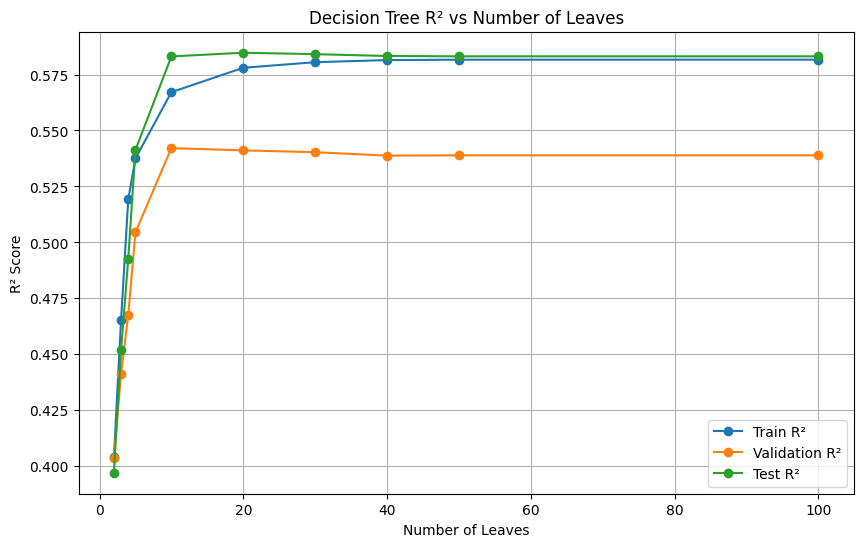

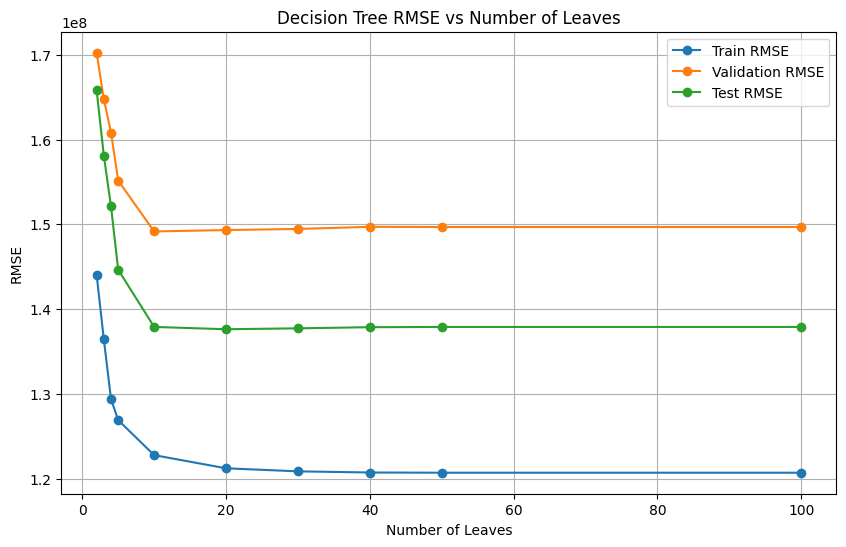

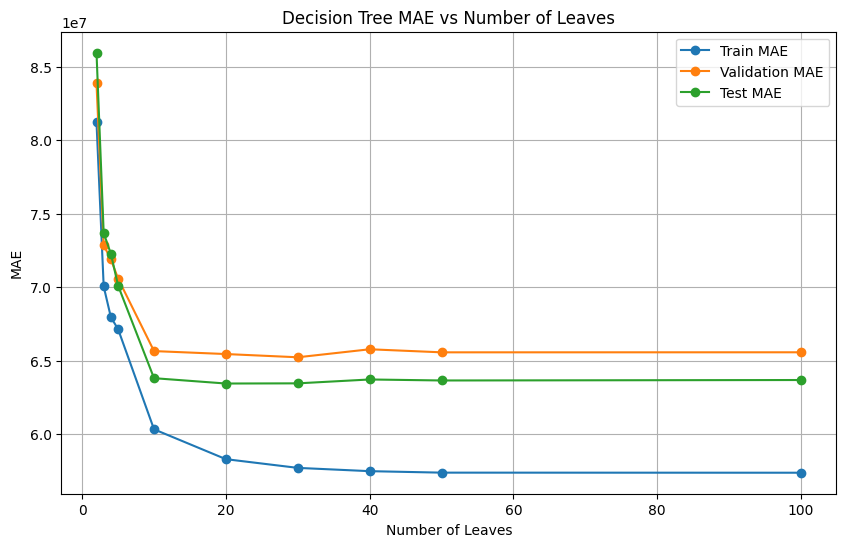

Best hyperparameters: num_leaves=10
Best R² scores: Train=0.5671, Val=0.5421, Test=0.5831
Best RMSE scores: Train=1.228e+08, Val=1.492e+08, Test=1.379e+08
Best MAE scores: Train=6.033e+07, Val=6.565e+07, Test=6.381e+07


In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.tree import DecisionTreeRegressor

num_leaves_range = [2, 3, 4, 5, 10, 20, 30, 40, 50, 100]

results = {}

for num_leaves in num_leaves_range:
    print(f"Training with num_leaves={num_leaves}")
    
    model = DecisionTreeRegressor(
        max_depth=12,
        min_samples_leaf=40,
        max_leaf_nodes=num_leaves,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_val = r2_score(y_val, y_val_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    results[num_leaves] = {
        'train': {
            'r2': r2_train,
            'rmse': rmse_train,
            'mae': mae_train
        },
        'val': {
            'r2': r2_val,
            'rmse': rmse_val,
            'mae': mae_val
        },
        'test': {
            'r2': r2_test,
            'rmse': rmse_test,
            'mae': mae_test
        }
    }

    print(f"  R² Train={r2_train:.4f}, Val={r2_val:.4f}, Test={r2_test:.4f}")
    print(f"  RMSE Train={rmse_train:.3e}, Val={rmse_val:.3e}, Test={rmse_test:.3e}")
    print(f"  MAE Train={mae_train:.3e}, Val={mae_val:.3e}, Test={mae_test:.3e}")

r2_train_scores = [results[nl]['train']['r2'] for nl in num_leaves_range]
r2_val_scores = [results[nl]['val']['r2'] for nl in num_leaves_range]
r2_test_scores = [results[nl]['test']['r2'] for nl in num_leaves_range]

rmse_train_scores = [results[nl]['train']['rmse'] for nl in num_leaves_range]
rmse_val_scores = [results[nl]['val']['rmse'] for nl in num_leaves_range]
rmse_test_scores = [results[nl]['test']['rmse'] for nl in num_leaves_range]

mae_train_scores = [results[nl]['train']['mae'] for nl in num_leaves_range]
mae_val_scores = [results[nl]['val']['mae'] for nl in num_leaves_range]
mae_test_scores = [results[nl]['test']['mae'] for nl in num_leaves_range]

plt.figure(figsize=(10, 6))
plt.plot(num_leaves_range, r2_train_scores, marker='o', label='Train R²')
plt.plot(num_leaves_range, r2_val_scores, marker='o', label='Validation R²')
plt.plot(num_leaves_range, r2_test_scores, marker='o', label='Test R²')
plt.xlabel('Number of Leaves')
plt.ylabel('R² Score')
plt.title('Decision Tree R² vs Number of Leaves')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(num_leaves_range, rmse_train_scores, marker='o', label='Train RMSE')
plt.plot(num_leaves_range, rmse_val_scores, marker='o', label='Validation RMSE')
plt.plot(num_leaves_range, rmse_test_scores, marker='o', label='Test RMSE')
plt.xlabel('Number of Leaves')
plt.ylabel('RMSE')
plt.title('Decision Tree RMSE vs Number of Leaves')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(num_leaves_range, mae_train_scores, marker='o', label='Train MAE')
plt.plot(num_leaves_range, mae_val_scores, marker='o', label='Validation MAE')
plt.plot(num_leaves_range, mae_test_scores, marker='o', label='Test MAE')
plt.xlabel('Number of Leaves')
plt.ylabel('MAE')
plt.title('Decision Tree MAE vs Number of Leaves')
plt.grid(True)
plt.legend()
plt.show()